# Proof of Concept:  

# (1) of 2

# Experimentation with Demand Side Loan Pricing

# European Option Pricing with Binomial Tree using QuanLib Python 

# Need to Change Business Object to a Loan

In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# option data is made up to prove concept

maturity_date = ql.Date(15, 1, 2022)
spot_price = 127.62
strike_price = 130
volatility = 0.20 # the historical vols for a year
dividend_rate =  0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(10, 5, 2021)
ql.Settings.instance().evaluationDate = calculation_date

# Intremediate pricing in the middle of the deal

In [3]:
# construct the European Option . . . structural parameterization

payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

# Black-Scholes-Merton

In [4]:
# Old School

spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)

# Theoretical Price 

In [5]:
# Setting the Trajectory for Pricing

european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print ("The theoretical price is ", bs_price)

The theoretical price is  6.721084861085299


# Pricing Computation with the Binomial-Tree Approach

In [6]:
def binomial_price(bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    european_option.setPricingEngine(binomial_engine)
    return european_option.NPV()

steps = range(2, 100, 1)
prices = [binomial_price(bsm_process, step) for step in steps]

# Convergence of Binomial-Tree Approach 

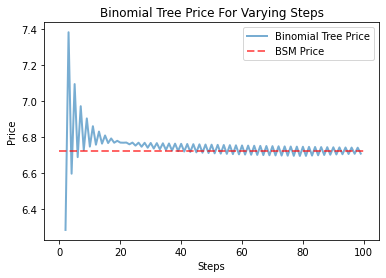

In [7]:
plt.plot(steps, prices, label="Binomial Tree Price", lw=2, alpha=0.6)
plt.plot([0,100],[bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()

#### Similar to the Dirac Delta Function

# (2) of 2 Valuing Bonds with Credit Spreads

# Experimentation with Credit Spreads in Loan Pricing

In [8]:
calc_date = ql.Date(5, 11, 2021)
ql.Settings.instance().evaluationDate = calc_date

### For simplicity assume the Treasury Curve is flat . . can relax assumption later

#### Starting with a 15 basis point to shock later

In [9]:
flat_rate = ql.SimpleQuote(0.0015)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates()
ts_yield = ql.FlatForward(calc_date, rate_handle, day_count)
ts_handle = ql.YieldTermStructureHandle(ts_yield)

### Bond Construction

In [10]:
issue_date = ql.Date(15, 8, 2021)
maturity_date = ql.Date(31, 12, 2022)
tenor = ql.Period(ql.Semiannual)
calendar = ql.UnitedStates()
bussiness_convention = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = False
schedule = ql.Schedule (issue_date, maturity_date, 
                        tenor, calendar, 
                        bussiness_convention,
                        bussiness_convention, 
                        date_generation, 
                        month_end)

In [11]:
settlement_days = 2
day_count = ql.Thirty360()
coupon_rate = .0305
coupons = [coupon_rate]

# Fixed Rate Bond Construction
settlement_days = 0
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days, 
    face_value, 
    schedule, 
    coupons, 
    day_count)

### Fixed Rate Bond Object initiated so let's create Discounting Bond Engine to value the bond

In [12]:
bond_engine = ql.DiscountingBondEngine(ts_handle)
fixed_rate_bond.setPricingEngine(bond_engine)
fixed_rate_bond.NPV()

104.0212313170282

### Incorporating the Credit Spreads with 50 basis point on top of the initial 15 basis point

In [13]:
flat_rate.setValue(0.0065)
fixed_rate_bond.NPV()

103.42022086191355

### Reset the flat rate back to 15 basis points

In [14]:
flat_rate.setValue(0.0015)
fixed_rate_bond.NPV()

104.0212313170282